# Hog combined with Canny feature testing

En aquest fitxer, ens encarregarem de testejar l'evaluació del model amb la característica individual HOG(Histogram of Oriented Graphics) and Canny.

## 1. Configuració

Primer ens encarregarem d'importar totes les llibraries necessàries i definir un FeatureTransformer amb els paràmetres corresponents a la nostra feature.

In [1]:
import cv2
import os
import skimage.feature
from FeatureTransformer import FeatureTransformer
from Utils import process_images_in_folder, process_images_in_folder2
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

In [2]:
transformer = FeatureTransformer()
hog_params = {
    'orientations': 9,
    'pixels_per_cell': (8, 8),
    'cells_per_block': (2, 2),
    'block_norm': 'L2-Hys',
    'visualize': False,
    'transform_sqrt': True,
    'feature_vector': True
}
canny_params = {
    'sigma': 1.0,           
    'low_threshold': 0.1,   
    'high_threshold': 0.2,  
    'mask': None,           
    'use_quantiles': False, 
}
customFeature=[skimage.feature.hog,hog_params, skimage.feature.canny, canny_params]

## 2. Feature extraction

En aquesta part, definirem les variables necessàries per a l'entrenament i l'avaluació del model. També començarem a extreure característiques (features) de les imatges.

In [3]:
x_train=[]
y_train=[]
x_test=[]
y_test=[]

In [4]:
train_folder_path = '../data/train'
test_folder_path = '../data/test'

# Extract features from training data
print('*********************TRAINING*********************')
for class_folder in os.listdir(train_folder_path):
    print("Extraguent features de la classe: " + str(class_folder))
    class_folder_path = os.path.join(train_folder_path, class_folder)
    process_images_in_folder2(transformer,customFeature,class_folder_path,class_folder,x_train,y_train)

# Extract features from testing data
print('*********************TESTING*********************')
for class_folder in os.listdir(test_folder_path):
    print("Extraguent features de la classe: " + str(class_folder))
    class_folder_path = os.path.join(test_folder_path, class_folder)
    process_images_in_folder2(transformer,customFeature,class_folder_path,class_folder,x_test,y_test)

*********************TRAINING*********************
Extraguent features de la classe: bedroom
Extraguent features de la classe: Coast
Extraguent features de la classe: Forest
Extraguent features de la classe: Highway
Extraguent features de la classe: industrial
Extraguent features de la classe: Insidecity
Extraguent features de la classe: kitchen
Extraguent features de la classe: livingroom
Extraguent features de la classe: Mountain
Extraguent features de la classe: Office
Extraguent features de la classe: OpenCountry
Extraguent features de la classe: store
Extraguent features de la classe: Street
Extraguent features de la classe: Suburb
Extraguent features de la classe: TallBuilding
*********************TESTING*********************
Extraguent features de la classe: bedroom
Extraguent features de la classe: coast
Extraguent features de la classe: forest
Extraguent features de la classe: highway
Extraguent features de la classe: industrial
Extraguent features de la classe: insidecity
Ext

Finalment, ens encarregam de que estiguin en el format correcte per a passar al model.

In [9]:
x_train = np.array(x_train).reshape(len(x_train), -1)
x_test = np.array(x_test).reshape(len(x_test), -1)

## 3. Fine Tuning

En aquest apartat, ens encarregarem de trobar les millors configuracions possibles per al nostre model amb el mètode GridSearchCV de Sklearn. Escollirem una llista de paràmetres amb diferents valors i imprimirem per pantalla el millor estimador.

In [8]:
param_grid = {'C': [0.1,1, 10, 100],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ..................................C=0.1, kernel=rbf; total time=  32.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  32.4s
[CV] END ..................................C=0.1, kernel=rbf; total time=  32.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  32.5s
[CV] END ..................................C=0.1, kernel=rbf; total time=  32.1s
[CV] END .................................C=0.1, kernel=poly; total time=  26.8s
[CV] END .................................C=0.1, kernel=poly; total time=  27.2s
[CV] END .................................C=0.1, kernel=poly; total time=  27.3s
[CV] END .................................C=0.1, kernel=poly; total time=  27.7s
[CV] END .................................C=0.1, kernel=poly; total time=  27.8s
[CV] END ..............................C=0.1, kernel=sigmoid; total time=  31.7s
[CV] END ..............................C=0.1, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'kernel': ['rbf', 'poly', 'sigmoid']},
             verbose=2)

In [9]:
print(grid.best_estimator_)

SVC(C=1, kernel='poly')


## 4. Training model

Ara, tenint una configuració optimitzada per al model, hauríem de poder entrenar-lo i obtenir un bon resultat.

In [11]:
model = SVC(C=10, kernel='sigmoid', random_state=33)
model.fit(x_train,y_train)

SVC(C=10, kernel='sigmoid', random_state=33)

## 5. Evaluating model

Finalment, predirem les nostres dades definides per provar-les i les compararem amb els valors esperats reals. El nostre objectiu és obtenir un % de precisió d'encerts del nostre model.

In [12]:
y_meu = model.predict(x_test)

In [13]:
precision_meu = accuracy_score(y_test, y_meu)
print(f"   Accuracy   : {precision_meu}")

   Accuracy   : 0.49581239530988275


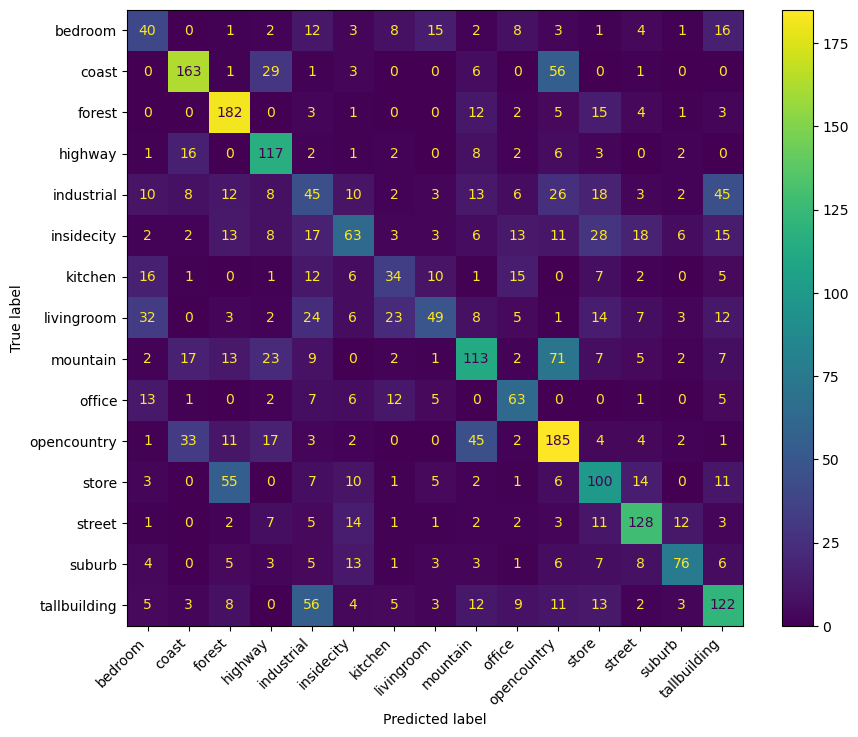

In [14]:
cm=confusion_matrix(y_test, y_meu, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()